In [7]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import json
import csv
import getpass
import os
import sys

In [2]:
e2e_folder = "../../../../test/e2e/"
loadtime_folder = "../../../../test/loadtime/"

In [5]:
rates = range(1000, 100, -50)
print(rates)
timeout = 60
base_config = f"{e2e_folder}/networks/epoch.toml"
modified_config = f"{e2e_folder}/networks/simple_modified.toml"
aggregate_file = "aggregated_out.csv"

# sudo_password = getpass.getpass("Enter sudo password: ")
# subprocess.run(["sudo", "-S", "echo", "test"], input=sudo_password.encode())

# Clear old aggregate file
if os.path.exists(aggregate_file):
    os.remove(aggregate_file)

# Run experiments
for i, rate in enumerate(rates):
    print(f"Running test with load_rate = {rate}ms")

    # Modify the config file
    with open(base_config, "r") as src, open(modified_config, "w") as dst:
        for line in src:
            if line.startswith("load_rate"):
                dst.write(f"load_rate = \"{rate}ms\"\n")
            else:
                dst.write(line)

    # Run the test
    test_cmd =f"{e2e_folder}build/runner -p -f {modified_config} benchmark"
    stop_cmd = f"{e2e_folder}build/runner -p -f {modified_config} stop"

    while True:
        try:
            subprocess.run(test_cmd, shell=True, timeout=timeout)
            break
        except:
            print(f"Timing out after {timeout}s")
    
    subprocess.run(stop_cmd, shell=True, timeout=60)

    report_cmd = [
        # "sudo", "-S",
        f"{loadtime_folder}/build/report",
        "--nstates", "4",
        "--database-type", "goleveldb",
        "--data-dir", f"{e2e_folder}/networks/simple_modified/validator00/data",
        "--csv", f"out_{rate}.csv"
    ]
    subprocess.run(report_cmd, timeout=60)

    print("-------- Aggregating results...")
    with open(f"out_{rate}.csv", "r") as infile, open(aggregate_file, "a") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for j, row in enumerate(reader):
            if i == 0 and j == 0:
                writer.writerow(row)  # header
            elif j > 0:
                row[0] = f"{rate}"  # update experiment_id
                row[5] = 1000 // rate
                writer.writerow(row)


range(1000, 950, -50)
Running test with load_rate = 1000ms
Testnet load rate: 1s
I[2025-08-20|21:20:20.864] Removing Docker containers and networks      
I[2025-08-20|21:20:21.030] cleanup dir                                  msg="Removing testnet directory `../../../../test/e2e//networks/simple_modified`"
I[2025-08-20|21:20:21.313] setup                                        msg="Generating testnet files in `../../../../test/e2e//networks/simple_modified`"
I[2025-08-20|21:20:21.335] Starting initial network nodes...            
I[2025-08-20|21:20:21.336] load                                         msg="Starting transaction load (16 workers)..."
E[2025-08-20|21:20:21.343] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5704/v1\": dial tcp 127.0.0.1:5704: connect: connection refused"
E[2025-08-20|21:20:21.343] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5701/v1\": dial tcp 127.0.0.1:5701: connect: 

INFO	Reading aggregated_out.csv...
INFO	Found experiment 1000 with rate=1, connections=1
INFO	For 1 connection(s): throughput rate = 5.742379 tx/s	average latency = 2.928537s


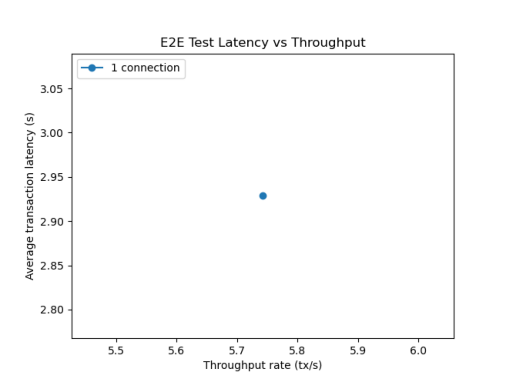

In [8]:
plot_cmd = [
    sys.executable, "../latency_throughput.py",
    "-t", "E2E Test Latency vs Throughput",
    "e2e_latency_plot.png",
    "aggregated_out.csv"
]
subprocess.run(plot_cmd)

# show image of the plot
plt.imshow(plt.imread("e2e_latency_plot.png"))
plt.axis('off')
plt.show()